# Test Method

In [2]:
# Song Liu (song.liu@bristol.ac.uk), 01-06-2023
# All rights reserved.

# load csv files from archive folder
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.nn import functional as F
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, TensorDataset
from tqdm import tqdm 


def torch_normcdf(x: torch.Tensor) -> torch.Tensor:
    return 0.5 * (1 + torch.erf(x / (2**0.5)))


# Regulariser Framework 
class GenReg(ABC, nn.Module): 
    def __init__(self, loss = nn.L1Loss(), regtype:str='fp'):
        super().__init__()
        self.loss = loss    
        if regtype == 'fp':
            self.test_labs = [0]
        elif regtype == 'tp':
            self.test_labs = [1]
        elif regtype == 'both':
            self.test_labs = [0, 1]
        else:
            raise ValueError('type should be one of fp, tp, both')
        self.regtype = regtype.lower()
    
    @abstractmethod
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor):
        pass
    
    def forward(self, labels, scores, group_data, **kwargs):
        groups = torch.unique(group_data)
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            # Iterate over protected groups
            for group in groups:
                label_score = scores[labels==test_label]
                labelgroup_score = scores[(group_data==group) & (labels==test_label)]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label, **kwargs)
        return loss


class KDEReg(GenReg):
    a = 0.4920
    b = 0.2887
    c = 1.1893
    
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return torch.exp(-KDEReg.a*y**2 - KDEReg.b*y - KDEReg.c)
    
    def __init__(self, h: int, casttoprob=False, loss = nn.L1Loss(), regtype: str= 'fp' ):
        super().__init__(loss, regtype)
        self.h = h
        self.casttoprob=casttoprob
    
    def subgroup_reg(self, scores_1:Tensor, scores_2:Tensor, test_label: int, tau: int):
        # Cast onto [0,1] if necessary
        if self.casttoprob:
            scores_1 = torch.sigmoid(scores_1)
            scores_2 = torch.sigmoid(scores_2)
        # Caclaulte kernel CDF estimates
        kernel_1 = torch.mean(self.F_est((tau-scores_1)/self.h))
        kernel_2 = torch.mean(self.F_est((tau-scores_2)/self.h))
        return self.loss(kernel_1, kernel_2)


class KDERegExact(KDEReg):
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return 1-torch_normcdf(y)


class BCEReg(GenReg):
    def __init__(self, logit=False, loss = nn.L1Loss(), regtype:str='fp'):
        super().__init__(loss, regtype)
        if logit:
            self.regloss = F.binary_cross_entropy_with_logits
        else:
            self.regloss = F.binary_cross_entropy
    def subgroup_reg(self, scores_1: Tensor, scores_2: Tensor, test_label:int):
        bce_1 = self.regloss(scores_1, torch.ones_like(scores_1)*test_label)
        bce_2 = self.regloss(scores_2, torch.ones_like(scores_2)*test_label)
        return self.loss(bce_1, bce_2)


def equality_loss(labels, preds, group_data, regtype: str =  "fp"):
    groups = torch.unique(group_data)
    if regtype == 'fp':
        test_labs = [0]
    elif regtype == 'tp':
        test_labs = [1]
    elif regtype == 'both':
        test_labs = [0, 1]
     
    loss = 0
    # Iterate over true label types
    for test_label in test_labs:
        # Iterate over protected groups
        for group in groups:
            label_preds = preds[labels==test_label]
            grouplabel_preds = preds[(group_data==group) & (labels==test_label)]
            loss += torch.abs(torch.mean(grouplabel_preds)-torch.mean(label_preds))
        return loss


class PWKDEReg(KDEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1, **kwargs):
        # Get data groups
        groups = torch.unique(torch.cat((group_data0, group_data1)))
        # Combine scores
        scores = {"0": scores0, "1": scores1}
        group_data = {"0": group_data0, "1": group_data1} 
        loss = 0
        # Iterate over true label types
        for test_label in self.test_labs:
            label_key = str(test_label)
            # Iterate over protected groups
            for group in groups:
                label_score = scores[label_key]
                labelgroup_score = scores[label_key][group_data[label_key]==group]
                loss += self.subgroup_reg(labelgroup_score, label_score, test_label, **kwargs)
        return loss
    

class PWKDERegExact(PWKDEReg):
    @staticmethod
    def F_est(y: Tensor)->Tensor:
        return KDERegExact.F_est(y)


class PWBCEReg(BCEReg): 
    # Re-define forward method to account for already separated scores  
    def forward(self, scores0, scores1, group_data0, group_data1):
        return PWKDEReg.forward(self, scores0, scores1, group_data0, group_data1)
    

class Classifier(nn.Module):
    def __init__(self, score_model, tau: int = 0.5, casttoprob: bool = False):
        super().__init__()
        self.score_model = score_model
        self.tau: Tensor
        self.register_buffer('tau', torch.tensor(tau))
        self.casttoprob = casttoprob

    def forward(self, x):
        x = self.score_model(x)
        return x
    def predict(self, x):
        x = self.forward(x)
        if self.casttoprob:
            x = torch.sigmoid(x)
        return (x > self.tau).float()
    

def update_tau(classifier: Classifier, scores0: Tensor, scores1: Tensor, type="fp", value=0.1, prior=None):
    if type == "fp":
        classifier.tau = torch.quantile(scores0, 1-value)
    elif type == "tp":
        classifier.tau = torch.quantile(scores1, 1-value)
    elif type == "fdr":
        if prior is not None:
            # Adjust scores to give true prior if necessary
            n0, n1 = scores0.shape[0], scores1.shape[0]
            current_prior = n1/(n1+n0)
            if current_prior < prior:
                rep_count = int(n0*prior/(1-prior))
                scores1 = scores1[torch.randint(0, n1, (rep_count,)).long()]
            else:
                rep_count = int(n1*(1-prior)/prior)
                scores0 = scores0[torch.randint(0, n0, (rep_count,)).long()]
        # Get scores and labels
        scores = torch.cat((scores0, scores1))
        labels = torch.cat((torch.zeros_like(scores0), torch.ones_like(scores1)))
        quant = 1-fdr_score_prop1(scores, labels, value)
        classifier.tau = torch.quantile(scores,quant)
    elif type == "prop1":
        scores = torch.cat((scores0, scores1))
        classifier.tau = torch.quantile(scores, 1-value)
    else:
        raise ValueError("type should be one of fp, tp")
def fdr_score_prop1(scores,labels, value):
    # Sort both
    scores, indices = torch.sort(scores, descending=True)
    labels = labels[indices]
    fdrs = (torch.cumsum(1-labels, dim=0))/torch.arange(1, scores.shape[0]+1)
    quantile = torch.max(torch.nonzero(fdrs < value))/scores.shape[0]
    return quantile


ROC space is $[0,1]^2$, where the x axis is False Positive Rate (FPR) and y axis is True Positive Rate (TPR).

Recall, $\mathrm{TPR} = \frac{\mathrm{TP}}{\mathrm{TP} + \mathrm{FN}}$ and $\mathrm{FPR} = \frac{\mathrm{FP}}{\mathrm{FP} + \mathrm{TN}}$.

In [3]:
base = pd.read_csv('../../archive/Variant I.csv')
# remove 'income', 'customer_age', 'employment_status' columns as they are protected
sensitive = base[['income', 'customer_age', 'employment_status']]
# Get filter for our employment groups
employment_status = base['employment_status'].astype("category").cat.codes
employment_filter = base['employment_status'].isin(['CA', 'CB'])
base = base.drop(columns=['income', 'customer_age', 'employment_status'])
# convert categorical variables in 'payment_type' to integers
base['payment_type'] = base['payment_type'].astype('category')
base['housing_status'] = base['housing_status'].astype('category')
base['source'] = base['source'].astype('category')
base['device_os'] = base['device_os'].astype('category')

cat_columns = base.select_dtypes(['category']).columns
base[cat_columns] = base[cat_columns].apply(lambda x: x.cat.codes)

base_pd = base

missing_value = -10 # missing values are replaced by this!

def mean_std_scale(x): return (x - x.mean())/x.std()

df = pd.DataFrame(index=range(len(base)), columns=[])
df['fraud_bool'] = base['fraud_bool'].copy().astype(float)
df['name_email_similarity'] = base['name_email_similarity'].copy()

## scale
prev = base['prev_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['prev_address_months_count'] = prev.copy()

prev = base['current_address_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['current_address_months_count'] = prev.copy()

df['days_since_request'] = mean_std_scale(base['days_since_request']).copy()
df['intended_balcon_amount'] = mean_std_scale(base['intended_balcon_amount']).copy()

pt = pd.get_dummies(base, columns=['payment_type'])
for i in range(5): df[f'payment_type_{i}'] = pt[f'payment_type_{i}'].astype(float)


df['zip_count_4w'] = mean_std_scale(base['zip_count_4w'].copy().astype(float))

## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['velocity_6h', 'velocity_24h', 'velocity_4w',
            'bank_branch_count_8w', 'date_of_birth_distinct_emails_4w',
            'credit_risk_score']:
    df[col] = mean_std_scale(base[col]).copy()

df['email_is_free'] = base['email_is_free'].copy().astype(float)


pt = pd.get_dummies(base, columns=['housing_status'])
for i in range(7): df[f'housing_status_{i}'] = pt[f'housing_status_{i}'].astype(float)

df['phone_home_valid'] = base['phone_home_valid'].copy().astype(float)
df['phone_mobile_valid'] = base['phone_mobile_valid'].copy().astype(float)


prev = base['bank_months_count'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['bank_months_count'] = prev.copy()

df['has_other_cards'] = base['has_other_cards'].copy().astype(float)
df['foreign_request'] = base['foreign_request'].copy().astype(float)


## not sure these should be mean/std scaled tbh... maybe min/max scaling would be better
## https://www.dropbox.com/scl/fo/vg4b2hyapa9o9ajanbfl3/AL1RUfD1rAb5RBvgFQwc8eI/bank-account-fraud/documents?dl=0&preview=datasheet.pdf&rlkey=2r99po055q5pjbg1934ga0c8i&subfolder_nav_tracking=1
for col in ['proposed_credit_limit']:
    df[col] = mean_std_scale(base[col]).copy()


df['source'] = base['source'].copy().astype(float)

prev = base['session_length_in_minutes'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['session_length_in_minutes'] = prev.copy()


pt = pd.get_dummies(base, columns=['device_os'])
for i in range(5): df[f'device_os_{i}'] = pt[f'device_os_{i}'].astype(float)

df['keep_alive_session'] = base['keep_alive_session'].copy().astype(float)

prev = base['device_distinct_emails_8w'].copy().astype(float)
prev[prev > 0] = (prev[prev > 0] / prev.max()).copy()
prev[prev < 0] = missing_value
df['device_distinct_emails_8w'] = prev.copy()

df['device_fraud_count'] = base['device_fraud_count'].copy().astype(float)

pt = pd.get_dummies(base, columns=['month'])
for i in range(8): df[f'month_{i}'] = pt[f'month_{i}'].astype(float)

# For now filter to only get CA and CB employment_status values
# This is for simplicity and to be removed later.
df = df[employment_filter]
employment_status = employment_status[employment_filter]
income = sensitive["income"][employment_filter]


base_torch = torch.tensor(df.to_numpy()).float()

X = base_torch[:,1:]
y = base_torch[:,0]
group = torch.tensor(employment_status.to_numpy()).float()
income_group = (torch.tensor(income.to_numpy())>.5).float()

# class prior 
prior = torch.mean(y)

print('class prior for positive:', prior)
print('class prior for negative:', 1-prior)


(X_train, X_test, y_train, y_test, group_train,
group_test, income_train, income_test) = train_test_split(X, y, group, income_group, test_size=0.1, random_state=0)

class prior for positive: tensor(0.0118)
class prior for negative: tensor(0.9882)


In [4]:
def TPR(pred, label):
    TP = torch.sum((pred==1) & (label==1))
    FN = torch.sum((pred==0) & (label==1))
    return TP/(TP+FN)

def FPR(pred, label):
    FP = torch.sum((pred==1) & (label==0))
    TN = torch.sum((pred==0) & (label==0))
    return FP/(FP+TN)

def FDR(pred, label):
    FP = torch.sum((pred==1) & (label==0))
    TP = torch.sum((pred==1) & (label==1))
    return FP/(FP+TP)

def roc(pred, label, scores_probs=False):
    # If score are probabilities, we need to convert them to scores
    if scores_probs:
        pred = torch.log(pred/(1-pred))
    fpr, tpr = [], []
    tmax = max(pred)
    tmin = min(pred)
    for t in torch.linspace(tmin, tmax, 100):
        p = pred > t
        tpr.append(TPR(p, label))
        fpr.append(FPR(p, label))
    return fpr, tpr

def AUC(fpr, tpr):
    return sum([(tpr[i]+tpr[i-1])*(fpr[i-1]-fpr[i])/2 for i in range(1, len(fpr))])    

def aucloss(pred, label):
    if pred[label==1].shape[0] == 0: # you might end up with no positive samples
        print('no positive samples!')
    pos_pred = pred[label==1]
    neg_pred = pred[label==0]
    
    # hinge loss
    T = (neg_pred.T - pos_pred)
    loss = torch.max(T, torch.zeros_like(T))/2
    loss = torch.mean(loss, dim = 0)
    loss = torch.mean(loss)
    return loss

def paired_aucloss(scores0: Tensor, scores1: Tensor):
    """Calculate the auc loss for identical length tensor of class 0 scores and class 1 scores

    Args:
        scores0 (Tensor): Scores of x values from class 0 data
        scores1 (Tensor): Scores of x values from class 1 data

    Returns:
        Tensor: AUC loss 
    """
    loss = F.relu(scores0 - scores1 + 1)
    loss = torch.mean(loss)
    return loss

Do initial run of model. We will start with logitistic regression and $\tau=0.5$.

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:21<01:26, 21.54s/it]

Loss:  0.069, AUC:  0.577, Equality Error:  0.005


 40%|████      | 2/5 [00:40<01:00, 20.19s/it]

Loss:  0.063, AUC:  0.733, Equality Error:  0.003


 60%|██████    | 3/5 [00:59<00:39, 19.59s/it]

Loss:  0.058, AUC:  0.801, Equality Error:  0.002


 80%|████████  | 4/5 [01:18<00:19, 19.10s/it]

Loss:  0.059, AUC:  0.828, Equality Error:  0.001


100%|██████████| 5/5 [01:38<00:00, 19.71s/it]

Loss:  0.053, AUC:  0.842, Equality Error:  0.001


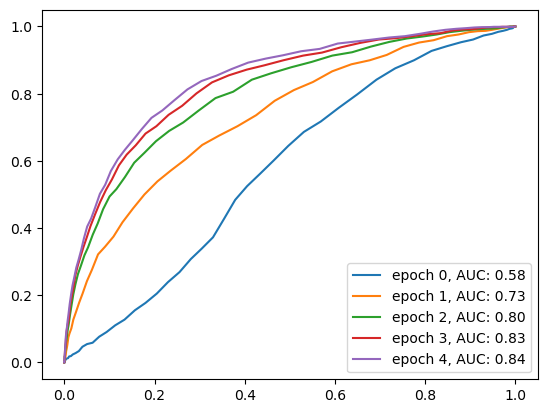

In [88]:
# Set up data
data = TensorDataset(
    X_train,
    y_train,
    group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCELoss()
tau = 0.5

model = Classifier(score_model = nn.Sequential(nn.Linear(d, 1), nn.Sigmoid()), tau=tau, casttoprob=False)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    pred_te = model(X_test).detach()[:,0]
    fpr, tpr = roc(pred_te, y_test, scores_probs=True)
    auc = AUC(fpr, tpr)
    equal_error  = equality_loss(y_test, pred_te, group_test, regtype='fp')
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    print(f"Loss: {loss.item(): 4.3f}, AUC: {auc.item(): 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


Have score as linear then take logits in loss. This should make AUC calculation better. Now also check the 

  0%|          | 0/5 [00:00<?, ?it/s]

Loss:  0.076


 20%|██        | 1/5 [00:19<01:19, 19.79s/it]

Loss:  0.076, AUC:  0.545, Equality Error:  0.000
Loss:  0.066


 40%|████      | 2/5 [00:40<01:00, 20.04s/it]

Loss:  0.066, AUC:  0.631, Equality Error:  0.000
Loss:  0.055


 60%|██████    | 3/5 [00:59<00:39, 19.91s/it]

Loss:  0.055, AUC:  0.675, Equality Error:  0.000
Loss:  0.062


 80%|████████  | 4/5 [01:20<00:20, 20.18s/it]

Loss:  0.062, AUC:  0.696, Equality Error:  0.000
Loss:  0.059


100%|██████████| 5/5 [01:42<00:00, 20.59s/it]

Loss:  0.059, AUC:  0.707, Equality Error:  0.000


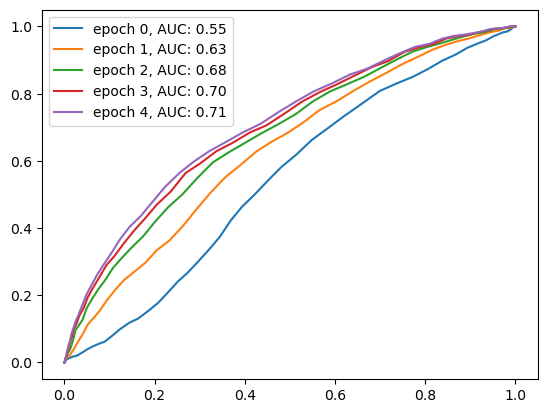

In [92]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
tau = 0.5

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss: {loss.item(): 4.3f}, AUC: {auc.item(): 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


## Test different $\tau$ where close FPR is less easy

### No Regularisation

tensor(0.0100)


 20%|██        | 1/5 [00:22<01:29, 22.45s/it]

Loss:  0.079, AUC:  0.560, Equality Error:  0.113


 40%|████      | 2/5 [00:42<01:03, 21.13s/it]

Loss:  0.060, AUC:  0.644, Equality Error:  0.104


 60%|██████    | 3/5 [01:03<00:42, 21.11s/it]

Loss:  0.064, AUC:  0.691, Equality Error:  0.103


 80%|████████  | 4/5 [01:23<00:20, 20.67s/it]

Loss:  0.062, AUC:  0.710, Equality Error:  0.100


100%|██████████| 5/5 [01:43<00:00, 20.77s/it]

Loss:  0.060, AUC:  0.721, Equality Error:  0.098


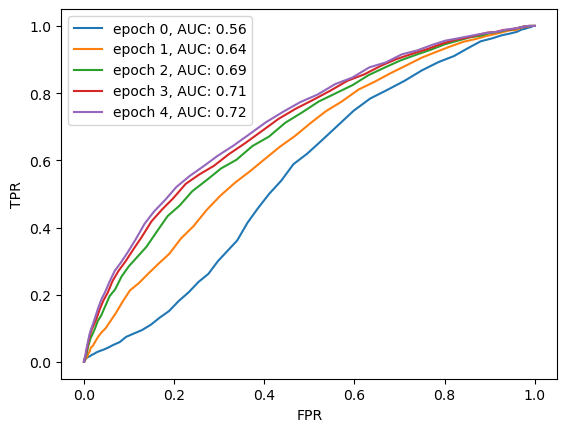

In [93]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
tau = 0.01

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

print(model.tau)
fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss: {loss.item(): 4.3f}, AUC: {auc: 4.3f}, Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()


### Regularisation

 20%|██        | 1/5 [00:11<00:46, 11.68s/it]

Loss:  0.078| Reg:  0.002| AUC:  0.490| Equality Error:  0.008


 40%|████      | 2/5 [00:24<00:37, 12.51s/it]

Loss:  0.065| Reg:  0.001| AUC:  0.601| Equality Error:  0.008


 60%|██████    | 3/5 [00:37<00:25, 12.82s/it]

Loss:  0.061| Reg:  0.000| AUC:  0.653| Equality Error:  0.008


 80%|████████  | 4/5 [00:53<00:13, 13.79s/it]

Loss:  0.065| Reg:  0.004| AUC:  0.677| Equality Error:  0.008


100%|██████████| 5/5 [01:06<00:00, 13.39s/it]

Loss:  0.073| Reg:  0.002| AUC:  0.690| Equality Error:  0.008


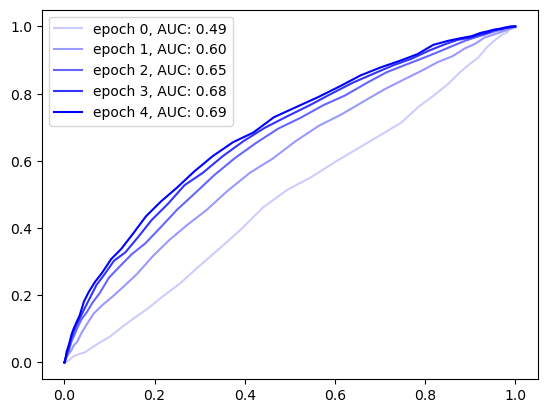

In [26]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
regularise = KDEReg(0.01, regtype='fp', casttoprob=True, loss=nn.L1Loss())


tau = 0.01
model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
nepochs = 5
alphas = torch.linspace(0.2, 1, nepochs)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(nepochs)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        reg = regularise(y, scores, group, tau=model.tau)
        loss += reg
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equality_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc), color="b", alpha=alphas[epoch].item())
        print(f"Loss: {loss.item(): 4.3f}| Reg: {reg.item(): 4.3f}| AUC: {auc: 4.3f}| Equality Error: {equal_error.item(): 4.3f}")
ax.legend()
plt.show()


### Exact Regularisation

 20%|██        | 1/5 [00:18<01:14, 18.68s/it]

Loss: 0.098 | Reg: 0.017 | Train Equality: 0.004 |  AUC: 0.440 | Equality Error: 0.020


 40%|████      | 2/5 [00:35<00:53, 17.79s/it]

Loss: 0.084 | Reg: 0.011 | Train Equality: 0.005 |  AUC: 0.478 | Equality Error: 0.020


 60%|██████    | 3/5 [00:53<00:35, 17.66s/it]

Loss: 0.074 | Reg: 0.002 | Train Equality: 0.022 |  AUC: 0.495 | Equality Error: 0.020


 80%|████████  | 4/5 [01:15<00:19, 19.38s/it]

Loss: 0.072 | Reg: 0.002 | Train Equality: 0.021 |  AUC: 0.505 | Equality Error: 0.020


100%|██████████| 5/5 [01:39<00:00, 19.84s/it]

Loss: 0.066 | Reg: 0.002 | Train Equality: 0.012 |  AUC: 0.515 | Equality Error: 0.020


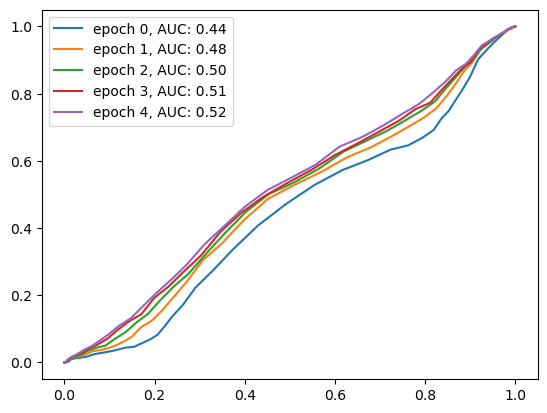

In [115]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
regularise = KDERegExact(h=0.01, regtype='fp', casttoprob=True, loss=nn.L1Loss())
tau = 0.01


model = Classifier(nn.Linear(d, 1),tau=tau, casttoprob=True)
lossfunc = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

fig,ax = plt.subplots()
# Train model
for epoch in tqdm(range(5)):
    for x, y, group in dataloader:
        optimizer.zero_grad()
        scores = model(x).squeeze()
        loss = lossfunc(scores, y)
        reg = regularise(y, scores, group, tau=model.tau)
        preds = model.predict(x).squeeze()
        train_equal_loss = equality_loss(y, preds, group, regtype='fp')
        loss += reg
        loss.backward()
        optimizer.step()
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        # Get Odd loss 
        equality_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 1.3f} | Reg:{reg.item(): 1.3f} | Train Equality:{train_equal_loss.item(): 1.3f} | ",
              f"AUC:{auc: 1.3f} | Equality Error:{equal_error.item(): 1.3f}")
ax.legend()
plt.show()


This does give equality although there is clearly a cost

### Test Regularisation

Loss:  0.085
Reg:  0.012
Equality Error:  0.020


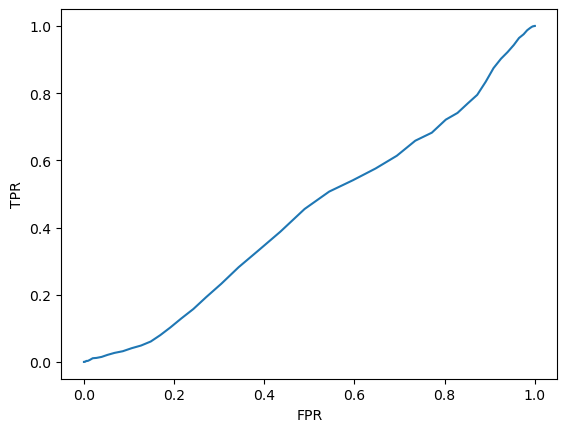

In [101]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
h=0.01
regularise = KDERegExact(h, regtype='fp', casttoprob=True, loss=nn.L1Loss())
tau = 0.01

model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)

# Train model
for x, y, group in dataloader:
    optimizer.zero_grad()
    scores = model(x).squeeze()
    loss = lossfunc(scores, y)
    reg = regularise(y, scores, group, tau=model.tau)
    loss += reg
    loss.backward()
    optimizer.step()
scheduler.step()
print(f"Loss: {loss.item(): 4.3f}")
print(f"Reg: {reg.item(): 4.3f}")
with torch.no_grad():
    scores_te = model(X_test).squeeze()
    pred_te = model.predict(X_test).squeeze()
    # Get Odd loss 
    print(f"Equality Error: {equality_loss(y_test, pred_te, group_test, regtype='fp').item(): 4.3f}")
    fpr, tpr = roc(scores_te, y_test)
    auc = AUC(fpr, tpr)
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')

In [112]:
print(model.tau)
print(equality_loss(y, model.predict(x).squeeze(), group, regtype='fp'))
temp_scores = model(x).squeeze()
print(equality_loss(y, (torch.sigmoid(temp_scores)>model.tau).float(), group, regtype='fp'))
print(equality_loss(y_test, pred_te, group_test, regtype='fp'))
print(regularise(y, scores, group, tau=model.tau))

tensor(0.0100)
tensor(0.0215)
tensor(0.0215)
tensor(0.0205)
tensor(0.0123, grad_fn=<AddBackward0>)


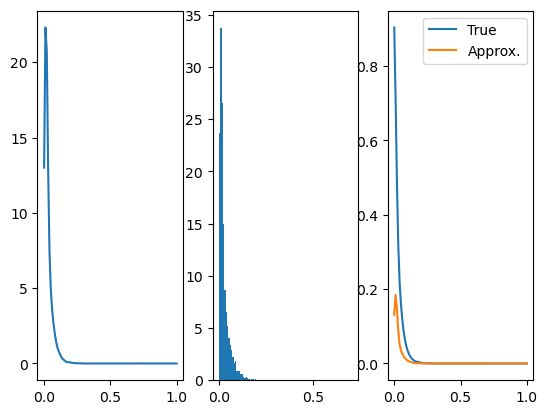

In [ ]:
# Plot kernel density of scores
scores = model(x).squeeze().detach()
scores0 = scores[y==0]
probs = torch.sigmoid(scores0)
# Plot densit on this group
def true_f_est(y: Tensor, data: Tensor, h)->Tensor:
    return (1/h)*torch.mean((1/(2*torch.pi)**0.5)*torch.exp(-0.5*((y.unsqueeze(-1)-data)/h)**2), dim=1)

def approx_f_est(y: Tensor, data: Tensor, h)->Tensor:
    return torch.mean(KDEReg.F_est((y.unsqueeze(-1)-data)/h), dim=1)

def true_F_est(y: Tensor, data: Tensor, h)->Tensor:
    norm = torch.distributions.Normal(0, h)
    return torch.mean(1-norm.cdf(y.unsqueeze(-1)-data), dim=1)

def approx_F_est(y: Tensor, data: Tensor, h)->Tensor:
    return torch.mean(KDEReg.F_est((y.unsqueeze(-1)-data)/h), dim=1)

y_vals = torch.linspace(0, 1, 100)
kde = true_f_est(y_vals, probs, h)
fig, ax = plt.subplots(ncols=3)
ax[0].plot(y_vals, kde)
ax[1].hist(probs, bins=100, density=True)
ax[2].plot(y_vals, true_F_est(y_vals, probs, h), label="True")
ax[2].plot(y_vals, approx_F_est(y_vals, probs, h), label="Approx.")
ax[2].legend() 

Here it is clear that the approximation given in the function is a poor one. We can use the exact normal cdf using the ERF function which actually isn't even slower.

## Multiple Experiments

In [116]:
# Set up data
data = TensorDataset(X_train, y_train, group_train)
dataloader = DataLoader(data, batch_size = 10000, shuffle = True, drop_last=True)
# Set-up model
d = X_train.shape[1]
lossfunc = nn.BCEWithLogitsLoss()
regularise = KDERegExact(0.01, regtype='fp', casttoprob=True)
tau = 0.01

equal_losses = []
aucs = []
rocs = []
lambs = [0.,0.25,0.5,0.75,1.]
nrep = 3
for lamb in tqdm(lambs):
    for j in range(nrep):
        # Set-up model
        model = Classifier(nn.Linear(d, 1), tau=tau, casttoprob=True)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
        # Train model
        for epoch in range(5):
            for x, y, group in dataloader:
                optimizer.zero_grad()
                scores = model(x).squeeze()
                loss = lossfunc(scores, y)
                loss += lamb*regularise(y, scores, group, tau=model.tau)
                loss.backward()
                optimizer.step()
            scheduler.step()
            
        with torch.no_grad():
            scores_te = model(X_test).squeeze()
            pred_te = model.predict(X_test).squeeze()
            # Get Odd loss 
            equal_loss = equality_loss(y_test, pred_te, group_test, regtype='fp').item()
            equal_losses.append(equal_loss)
            fpr, tpr = roc(scores_te, y_test)
            rocs.append([fpr, tpr])
            auc = AUC(fpr, tpr)
            aucs.append(auc)

100%|██████████| 5/5 [20:06<00:00, 241.37s/it]


In [117]:

# dim 0: lambda, dim 1: run
equal_losses = torch.tensor(equal_losses)
equal_losses = equal_losses.reshape(len(lambs), nrep, *equal_losses[0,...].shape)
aucs = torch.tensor(aucs)
aucs = aucs.reshape(len(lambs), nrep, *aucs[0,...].shape)
# dim 2: fpr or tpr, dim 3: value 
rocs = torch.tensor(rocs)
rocs = rocs.reshape(len(lambs), nrep, *rocs[0,...].shape)

torch.save({'equal_losses': equal_losses, 'aucs': aucs, 'rocs': rocs, "lambdas": lambs},
           'BCE_results.pt')

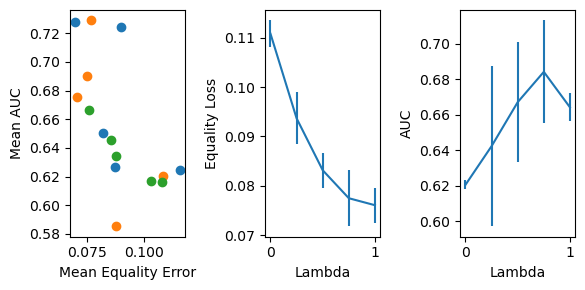

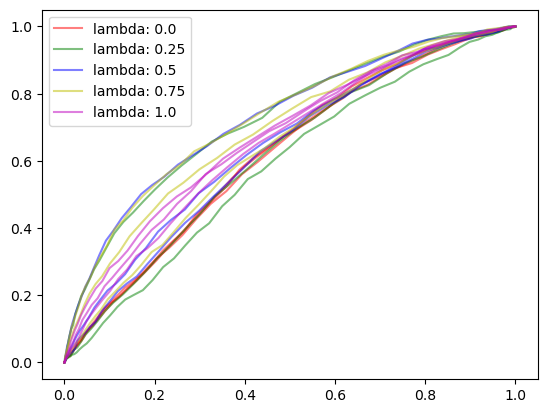

In [118]:
results = torch.load('BCE_results.pt')
equal_losses, aucs, rocs, lambs = [
    results[key] for key in ["equal_losses", "aucs", "rocs", "lambdas"]]
fig, ax = plt.subplots(ncols=3, figsize=(6,3))
ax[0].plot(equal_losses, aucs, 'o')
ax[0].set_xlabel('Mean Equality Error')
ax[0].set_ylabel('Mean AUC')
ax[1].errorbar(lambs, torch.mean(equal_losses, dim=1), yerr=1.96*torch.std(equal_losses, dim=1)/10**0.5, label = 'Mean Equal Loss')
ax[1].set_xlabel('Lambda')
ax[1].set_ylabel('Equality Loss')
ax[2].errorbar(lambs, torch.mean(aucs, dim=1), yerr=1.96*torch.std(aucs, dim=1)/10**0.5, label = 'Mean AUC')
ax[2].set_xlabel('Lambda')
ax[2].set_ylabel('AUC')
fig.tight_layout()

colours = ['r', 'g', 'b', 'y', 'm']
fig, ax = plt.subplots()
for i,lamb in enumerate(lambs):
    for j in range(aucs.shape[1]):
        if j == 0:
            ax.plot(rocs[i,j,0], rocs[i,j,1], label = f'lambda: {lamb}', color=colours[i], alpha=0.5)
        else:
            ax.plot(rocs[i,j,0], rocs[i,j,1],alpha=0.5, color=colours[i])
ax.legend()

# AUC Loss
Try with paired AUC as loss and threshold used to control FDR. Works well but equality error is v small.

 10%|█         | 1/10 [00:03<00:29,  3.28s/it]

Loss: 0.444 | Reg: 0.001 |  AUC: 0.839 | Equality Error: 0.000 |  Mean Score0:  1.010 | Var Score0: 3.613 FPR: 0.003 | TPR: 0.066 | FDR: 0.806


 20%|██        | 2/10 [00:06<00:25,  3.17s/it]

Loss: 0.398 | Reg: 0.002 |  AUC: 0.860 | Equality Error: 0.000 |  Mean Score0: -0.080 | Var Score0: 2.895 FPR: 0.001 | TPR: 0.035 | FDR: 0.679


 30%|███       | 3/10 [00:09<00:21,  3.08s/it]

Loss: 0.381 | Reg: 0.000 |  AUC: 0.863 | Equality Error: 0.000 |  Mean Score0: -0.481 | Var Score0: 2.277 FPR: 0.002 | TPR: 0.067 | FDR: 0.743


 40%|████      | 4/10 [00:12<00:17,  2.93s/it]

Loss: 0.367 | Reg: 0.001 |  AUC: 0.864 | Equality Error: 0.000 |  Mean Score0: -0.473 | Var Score0: 2.146 FPR: 0.002 | TPR: 0.067 | FDR: 0.746


 50%|█████     | 5/10 [00:14<00:14,  2.86s/it]

Loss: 0.361 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.000 |  Mean Score0: -0.464 | Var Score0: 2.105 FPR: 0.002 | TPR: 0.071 | FDR: 0.743


 60%|██████    | 6/10 [00:17<00:10,  2.67s/it]

Loss: 0.340 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -0.444 | Var Score0: 2.059 FPR: 0.002 | TPR: 0.065 | FDR: 0.742


 70%|███████   | 7/10 [00:19<00:07,  2.64s/it]

Loss: 0.377 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -0.449 | Var Score0: 2.069 FPR: 0.003 | TPR: 0.080 | FDR: 0.750


 80%|████████  | 8/10 [00:22<00:05,  2.55s/it]

Loss: 0.373 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -0.441 | Var Score0: 2.087 FPR: 0.003 | TPR: 0.075 | FDR: 0.744


 90%|█████████ | 9/10 [00:24<00:02,  2.45s/it]

Loss: 0.349 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -0.421 | Var Score0: 2.071 FPR: 0.002 | TPR: 0.069 | FDR: 0.742


100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

Loss: 0.366 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.000 |  Mean Score0: -0.439 | Var Score0: 2.075 FPR: 0.003 | TPR: 0.082 | FDR: 0.750


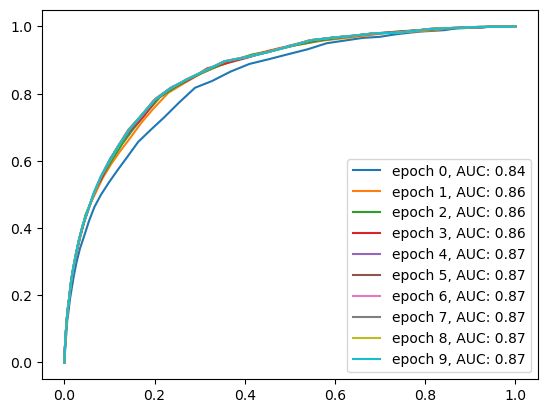

In [15]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=True)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=True)
mean_scores0 = []
var_scores0 = []
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # upscale scores to be same length as scores0
        update_tau(model, torch.sigmoid(scores0), torch.sigmoid(scores1),
                   type="prop1", value=prop_1)
        scores1 = scores1.repeat(batch_rep)
        # Use 0 scores to update tau to give 25% FP rate
        mean_scores0.append(torch.mean(scores0))
        var_scores0.append(torch.var(scores0))
    # Get quantile to control FDR
    scores = torch.sigmoid(model(X_train).squeeze())
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"Mean Score0: {mean_scores0[-1]: .3f} | Var Score0:{var_scores0[-1]: .3f}",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Here the equality error is very small though this is just becasue the False Positive Rate is very low. We now see if we can avoid castying to probability space alltogether

 10%|█         | 1/10 [00:01<00:13,  1.48s/it]

Loss: 0.448 | Reg: 0.000 |  AUC: 0.846 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.064 | FDR: 0.771


 20%|██        | 2/10 [00:02<00:11,  1.48s/it]

Loss: 0.424 | Reg: 0.000 |  AUC: 0.857 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.060 | FDR: 0.701


 30%|███       | 3/10 [00:04<00:11,  1.71s/it]

Loss: 0.384 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.065 | FDR: 0.728


 40%|████      | 4/10 [00:07<00:11,  1.87s/it]

Loss: 0.343 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.003 | TPR: 0.080 | FDR: 0.744


 50%|█████     | 5/10 [00:09<00:09,  1.92s/it]

Loss: 0.348 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.001 |  FPR: 0.002 | TPR: 0.066 | FDR: 0.732


 60%|██████    | 6/10 [00:11<00:08,  2.06s/it]

Loss: 0.356 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.074 | FDR: 0.737


 70%|███████   | 7/10 [00:13<00:06,  2.14s/it]

Loss: 0.374 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.078 | FDR: 0.736


 80%|████████  | 8/10 [00:15<00:04,  2.10s/it]

Loss: 0.389 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.069 | FDR: 0.736


 90%|█████████ | 9/10 [00:17<00:02,  2.15s/it]

Loss: 0.356 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.003 | TPR: 0.081 | FDR: 0.740


100%|██████████| 10/10 [00:20<00:00,  2.00s/it]

Loss: 0.359 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.000 |  FPR: 0.002 | TPR: 0.073 | FDR: 0.741


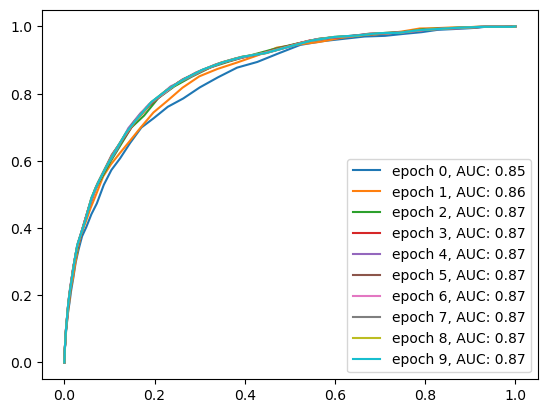

In [17]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)
mean_scores0 = []
var_scores0 = []
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        update_tau(model, scores0, scores1,
                   type="prop1", value=prop_1)
        # upscale scores to be same length as scores0 for use in paired AUC loss
        scores1 = scores1.repeat(batch_rep)
    # Get quantile to control FDR
    scores = torch.sigmoid(model(X_train).squeeze())
    prop_1 = fdr_score_prop1(scores, y_train, 0.8)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

It seems we can. Now try to test regularisation in these 2 spaces using FPR tied threshold.

 10%|█         | 1/10 [00:01<00:14,  1.61s/it]

Loss: 0.462 | Reg: 0.000 |  AUC: 0.838 | Equality Error: 0.018 |  FPR: 0.197 | TPR: 0.700 | FDR: 0.961


 20%|██        | 2/10 [00:03<00:12,  1.56s/it]

Loss: 0.399 | Reg: 0.001 |  AUC: 0.861 | Equality Error: 0.006 |  FPR: 0.198 | TPR: 0.770 | FDR: 0.957


 30%|███       | 3/10 [00:04<00:11,  1.70s/it]

Loss: 0.363 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.001 |  FPR: 0.203 | TPR: 0.780 | FDR: 0.958


 40%|████      | 4/10 [00:06<00:10,  1.80s/it]

Loss: 0.351 | Reg: 0.000 |  AUC: 0.865 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.781 | FDR: 0.957


 50%|█████     | 5/10 [00:08<00:09,  1.86s/it]

Loss: 0.347 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.196 | TPR: 0.773 | FDR: 0.956


 60%|██████    | 6/10 [00:10<00:07,  1.87s/it]

Loss: 0.337 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.783 | FDR: 0.957


 70%|███████   | 7/10 [00:12<00:05,  1.88s/it]

Loss: 0.369 | Reg: 0.000 |  AUC: 0.867 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.784 | FDR: 0.957


 80%|████████  | 8/10 [00:14<00:03,  1.87s/it]

Loss: 0.386 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.002 |  FPR: 0.200 | TPR: 0.783 | FDR: 0.957


 90%|█████████ | 9/10 [00:16<00:01,  1.92s/it]

Loss: 0.350 | Reg: 0.000 |  AUC: 0.866 | Equality Error: 0.002 |  FPR: 0.199 | TPR: 0.780 | FDR: 0.957


100%|██████████| 10/10 [00:18<00:00,  1.86s/it]

Loss: 0.383 | Reg: 0.001 |  AUC: 0.866 | Equality Error: 0.003 |  FPR: 0.202 | TPR: 0.784 | FDR: 0.957


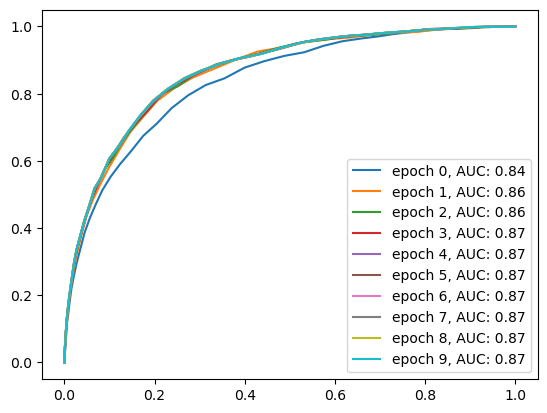

In [18]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
group_train0 = group_train[y_train==0]
group_train1 = group_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, group_train0)
data1 = TensorDataset(
    X_train1, group_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, group0), (x1, group1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, group0), (x1, group1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, group0, group1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, group_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

Again even with a higher FPR the equality error is very small. We try on a different sensitive class to see if this performs any differently.

## Income Based

 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

Loss: 0.430 | Reg: 0.049 |  AUC: 0.845 | Equality Error: 0.054 |  FPR: 0.189 | TPR: 0.691 | FDR: 0.960


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

Loss: 0.354 | Reg: 0.049 |  AUC: 0.865 | Equality Error: 0.052 |  FPR: 0.194 | TPR: 0.767 | FDR: 0.956


 30%|███       | 3/10 [00:05<00:12,  1.77s/it]

Loss: 0.347 | Reg: 0.038 |  AUC: 0.865 | Equality Error: 0.047 |  FPR: 0.204 | TPR: 0.781 | FDR: 0.958


 40%|████      | 4/10 [00:07<00:11,  1.97s/it]

Loss: 0.360 | Reg: 0.041 |  AUC: 0.866 | Equality Error: 0.049 |  FPR: 0.203 | TPR: 0.779 | FDR: 0.958


 50%|█████     | 5/10 [00:09<00:10,  2.15s/it]

Loss: 0.358 | Reg: 0.054 |  AUC: 0.866 | Equality Error: 0.050 |  FPR: 0.198 | TPR: 0.777 | FDR: 0.957


 60%|██████    | 6/10 [00:12<00:09,  2.26s/it]

Loss: 0.330 | Reg: 0.041 |  AUC: 0.867 | Equality Error: 0.051 |  FPR: 0.199 | TPR: 0.777 | FDR: 0.957


 70%|███████   | 7/10 [00:14<00:06,  2.16s/it]

Loss: 0.326 | Reg: 0.046 |  AUC: 0.867 | Equality Error: 0.052 |  FPR: 0.202 | TPR: 0.784 | FDR: 0.957


 80%|████████  | 8/10 [00:16<00:04,  2.12s/it]

Loss: 0.386 | Reg: 0.058 |  AUC: 0.867 | Equality Error: 0.050 |  FPR: 0.192 | TPR: 0.774 | FDR: 0.956


 90%|█████████ | 9/10 [00:18<00:02,  2.08s/it]

Loss: 0.358 | Reg: 0.039 |  AUC: 0.867 | Equality Error: 0.051 |  FPR: 0.197 | TPR: 0.779 | FDR: 0.956


100%|██████████| 10/10 [00:20<00:00,  2.06s/it]

Loss: 0.353 | Reg: 0.034 |  AUC: 0.867 | Equality Error: 0.052 |  FPR: 0.199 | TPR: 0.780 | FDR: 0.957


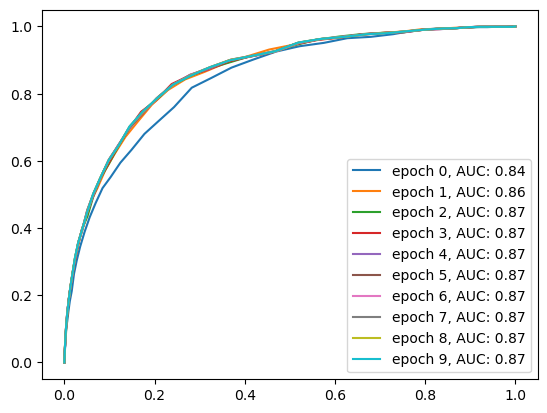

In [21]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.01, regtype='fp', casttoprob=False)
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 25% FP rate
model.tau = torch.quantile(scores0,torch.tensor([.75]))
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        # loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0, scores1,
                   type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

There does seem to be some non-trivial inequality and the regularisation term does seem to accurately predict this. We now try actually performing the regularisation

 10%|█         | 1/10 [00:01<00:13,  1.53s/it]

Loss: 0.521 | Reg: 0.013 |  AUC: 0.842 | Equality Error: 0.028 |  FPR: 0.198 | TPR: 0.729 | FDR: 0.959


 20%|██        | 2/10 [00:03<00:14,  1.85s/it]

Loss: 0.434 | Reg: 0.027 |  AUC: 0.854 | Equality Error: 0.034 |  FPR: 0.200 | TPR: 0.746 | FDR: 0.959


 30%|███       | 3/10 [00:05<00:13,  1.93s/it]

Loss: 0.402 | Reg: 0.018 |  AUC: 0.860 | Equality Error: 0.028 |  FPR: 0.210 | TPR: 0.772 | FDR: 0.959


 40%|████      | 4/10 [00:07<00:11,  1.97s/it]

Loss: 0.426 | Reg: 0.018 |  AUC: 0.858 | Equality Error: 0.019 |  FPR: 0.200 | TPR: 0.765 | FDR: 0.958


 50%|█████     | 5/10 [00:09<00:09,  1.93s/it]

Loss: 0.380 | Reg: 0.022 |  AUC: 0.858 | Equality Error: 0.019 |  FPR: 0.202 | TPR: 0.769 | FDR: 0.958


 60%|██████    | 6/10 [00:11<00:07,  1.98s/it]

Loss: 0.399 | Reg: 0.009 |  AUC: 0.859 | Equality Error: 0.019 |  FPR: 0.205 | TPR: 0.771 | FDR: 0.958


 70%|███████   | 7/10 [00:13<00:05,  1.95s/it]

Loss: 0.364 | Reg: 0.026 |  AUC: 0.859 | Equality Error: 0.020 |  FPR: 0.206 | TPR: 0.775 | FDR: 0.958


 80%|████████  | 8/10 [00:15<00:03,  1.96s/it]

Loss: 0.395 | Reg: 0.019 |  AUC: 0.860 | Equality Error: 0.021 |  FPR: 0.200 | TPR: 0.768 | FDR: 0.958


 90%|█████████ | 9/10 [00:17<00:01,  1.93s/it]

Loss: 0.398 | Reg: 0.024 |  AUC: 0.860 | Equality Error: 0.021 |  FPR: 0.203 | TPR: 0.772 | FDR: 0.958


100%|██████████| 10/10 [00:19<00:00,  1.94s/it]

Loss: 0.393 | Reg: 0.028 |  AUC: 0.860 | Equality Error: 0.021 |  FPR: 0.197 | TPR: 0.764 | FDR: 0.957


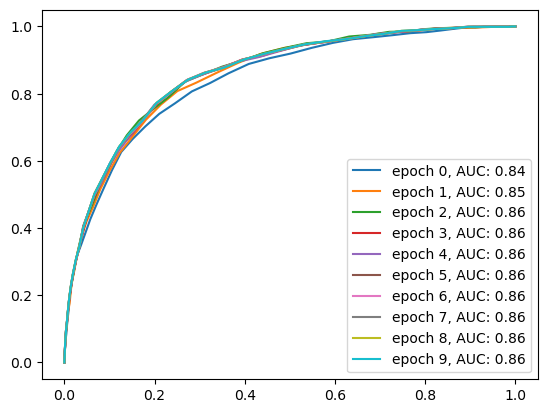

In [22]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
model.tau = torch.quantile(scores0.detach(),torch.tensor([.8]))
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

 10%|█         | 1/10 [00:01<00:12,  1.41s/it]

Loss: 0.560 | Reg: 0.005 |  AUC: 0.824 | Equality Error: 0.005 |  FPR: 0.199 | TPR: 0.702 | FDR: 0.961


 20%|██        | 2/10 [00:03<00:14,  1.85s/it]

Loss: 0.459 | Reg: 0.023 |  AUC: 0.851 | Equality Error: 0.018 |  FPR: 0.205 | TPR: 0.743 | FDR: 0.960


 30%|███       | 3/10 [00:06<00:16,  2.39s/it]

Loss: 0.389 | Reg: 0.020 |  AUC: 0.851 | Equality Error: 0.013 |  FPR: 0.199 | TPR: 0.736 | FDR: 0.959


 40%|████      | 4/10 [00:08<00:13,  2.25s/it]

Loss: 0.409 | Reg: 0.003 |  AUC: 0.851 | Equality Error: 0.007 |  FPR: 0.198 | TPR: 0.738 | FDR: 0.959


 50%|█████     | 5/10 [00:13<00:15,  3.06s/it]

Loss: 0.391 | Reg: 0.009 |  AUC: 0.855 | Equality Error: 0.012 |  FPR: 0.192 | TPR: 0.744 | FDR: 0.957


 60%|██████    | 6/10 [00:15<00:11,  2.76s/it]

Loss: 0.417 | Reg: 0.019 |  AUC: 0.855 | Equality Error: 0.012 |  FPR: 0.199 | TPR: 0.751 | FDR: 0.958


 70%|███████   | 7/10 [00:17<00:07,  2.62s/it]

Loss: 0.382 | Reg: 0.004 |  AUC: 0.854 | Equality Error: 0.009 |  FPR: 0.199 | TPR: 0.748 | FDR: 0.958


 80%|████████  | 8/10 [00:19<00:05,  2.50s/it]

Loss: 0.407 | Reg: 0.003 |  AUC: 0.854 | Equality Error: 0.008 |  FPR: 0.194 | TPR: 0.739 | FDR: 0.958


 90%|█████████ | 9/10 [01:50<00:30, 30.17s/it]

Loss: 0.374 | Reg: 0.005 |  AUC: 0.854 | Equality Error: 0.008 |  FPR: 0.203 | TPR: 0.752 | FDR: 0.959


100%|██████████| 10/10 [01:52<00:00, 11.25s/it]

Loss: 0.424 | Reg: 0.002 |  AUC: 0.854 | Equality Error: 0.008 |  FPR: 0.194 | TPR: 0.740 | FDR: 0.958


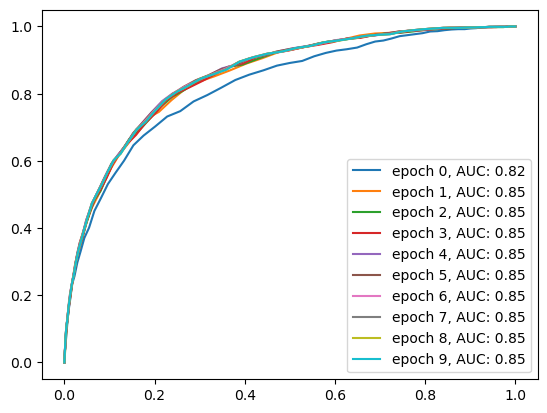

In [23]:
# Set up data
# Split into 0 and l data
X_train0 = X_train[y_train==0]
X_train1 = X_train[y_train==1]
income_train0 = income_train[y_train==0]
income_train1 = income_train[y_train==1]
# Set up dataloaders
data0 = TensorDataset(
    X_train0, income_train0)
data1 = TensorDataset(
    X_train1, income_train1) 
small_batch = 1000
batch_rep = 10
large_batch = small_batch*batch_rep
dataloader0 = DataLoader(data0, batch_size = large_batch, shuffle = True, drop_last=True)
dataloader1 = DataLoader(data1, batch_size = small_batch, shuffle = True, drop_last=True)

# Set-up model
d = X_train.shape[1]
model = Classifier(nn.Linear(d, 1), tau=0, casttoprob=False)
lossfunc = paired_aucloss
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=.5)
regularise = PWKDERegExact(0.1, regtype='fp', casttoprob=False)
prop_1=0.01
fig,ax = plt.subplots()
# Train model
# set-up initial scores
(x0, income0), (x1, income1) = next(iter(zip(dataloader0, dataloader1)))
scores0 = model(x0).squeeze()
scores1 = model(x1).squeeze()
reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
scores1 = scores1.repeat(batch_rep)
# Use 0 scores to update tau to give 20% FP rate
model.tau = torch.quantile(scores0.detach(),torch.tensor([.8]))
for epoch in tqdm(range(10)):
    for (x0, income0), (x1, income1) in zip(dataloader0, dataloader1):
        optimizer.zero_grad()
        loss = lossfunc(scores0, scores1)
        loss += 2*reg
        loss.backward()
        optimizer.step()
        scores0 = model(x0).squeeze()
        scores1 = model(x1).squeeze()
        reg = regularise(scores0, scores1, income0, income1, tau=model.tau)
        # Use 0 scores to update tau to give 25% FP rate
        update_tau(model, scores0.detach(), scores1.detach(), type="fp", value=0.2)
        # upscale scores to be same length as scores0
        scores1 = scores1.repeat(batch_rep)
    scheduler.step()
    with torch.no_grad():
        scores_te = model(X_test).squeeze()
        pred_te = model.predict(X_test).squeeze()
        fpr, tpr = roc(scores_te, y_test)
        auc = AUC(fpr, tpr)
        single_fpr = FPR(pred_te, y_test)
        single_tpr = TPR(pred_te, y_test)
        single_fdr = FDR(pred_te, y_test)
        equal_error = equality_loss(y_test, pred_te, income_test, regtype='fp')
        ax.plot(fpr, tpr, label = 'epoch %d, AUC: %0.2f' % (epoch, auc))
        print(f"Loss:{loss.item(): 0.3f} | Reg:{reg.item(): .3f} | ",
              f"AUC:{auc: .3f} | Equality Error:{equal_error.item(): .3f} | ",
              f"FPR:{single_fpr: .3f} | TPR:{single_tpr: .3f} | FDR:{single_fdr: .3f}")
ax.legend()
plt.show()

# Further Questions:
* Do we work with fairness for just 1 $\tau$ value or across all (like auc)?
* Do we use a different closeness metric for fairness than absolute erro in the probabilties?
* For multiple groups, do we take all combinations or regularise each separately?